# COMP90086 Final Project

Team Number: 55

Members: Einon McGrory-Perich (992697),     Xing Yang Goh (1001969)

In [2]:
import os 
import math
import matplotlib.pyplot as plt 
import numpy as np
import cv2
from tqdm import tqdm
import sys

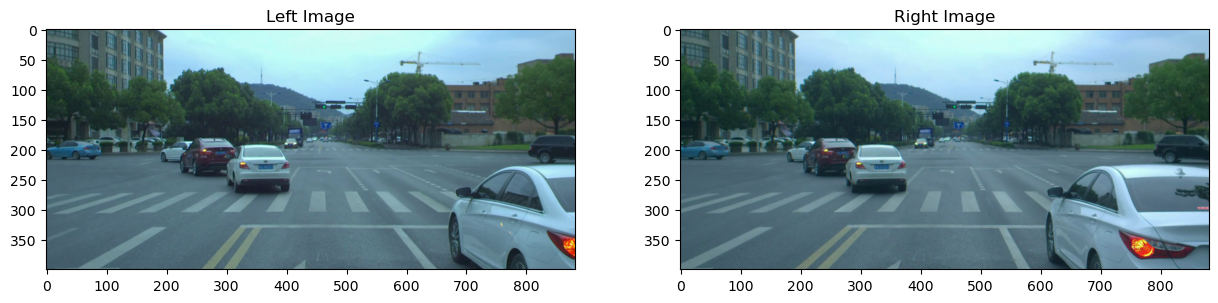

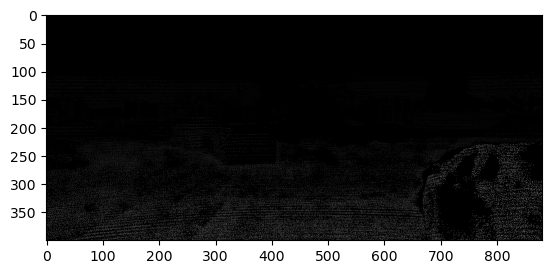

In [31]:
# Import images 
directory = './Dataset/'
allfiles = os.listdir(directory)

filenames = []

for filename in allfiles:
    if 'left' in filename:
        filenames.append(filename[0:filename.index('left')])

# List of files obtained

# Perform on first image for now 

file = filenames[0]

left_image_name = directory + file + 'left.jpg'
right_image_name = directory+ file + 'right.jpg'
disp_image_name = directory+ file + 'disparity.png'

# Read images and convert to RGB 
img_l = cv2.imread(left_image_name)
img_r = cv2.imread(right_image_name)

# Grey images
img_l_grey_full = np.int32(cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY))
img_r_grey_full = np.int32(cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY))


img_l = img_l[...,::-1]
img_r = img_r[...,::-1]

# Plot images 
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img_l)
plt.title('Left Image')

plt.subplot(1,2,2)
plt.imshow(img_r)
plt.title('Right Image')

plt.show()

img_d = cv2.imread(disp_image_name)
plt.imshow(img_d)

# note: can perform downscaling of the images to speed up computation at the cost of quality degradation
scale_percentage = 50
width = int(img_l_grey_full.shape[1] * scale_percentage / 100)
height = int(img_l_grey_full.shape[0] * scale_percentage / 100)
dim = (width, height)

img_l_grey = np.int32(cv2.resize(img_l_grey_full.astype('float32'), dim, interpolation = cv2.INTER_AREA))
img_r_grey = np.int32(cv2.resize(img_r_grey_full.astype('float32'), dim, interpolation = cv2.INTER_AREA))



Text(0.5, 1.0, 'SSD')

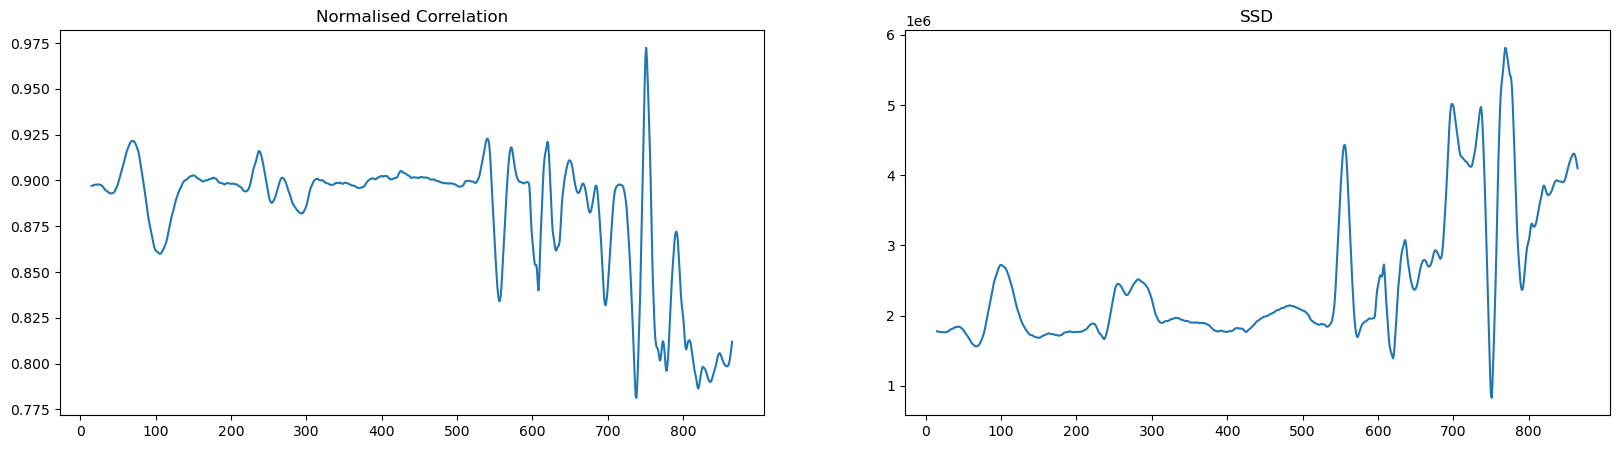

In [32]:
# As driving assume that any two points have the same y value (camera is flat)

# For every y value in both left and right
#     For every x value in left, find the corresponding SSD error (10x10 box) for each x point in right image
#     Select mininum error - treat this as corresponding point

# For every corresponding set of points, find the disparity, x-x'
#     Find depth z by estimating f and baseline distance


# Not certain if this function actually does what I imagine it does

# centre positions given by [row,column]

# sum of squared differenced method to find disparity between images   
def sum_squared_differences(img_l, img_r, centre_l, centre_r, boundary_size):
    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size

    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size
    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size
    
    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size
    
    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    # Error of RGB values
    # error = np.sum((img_l[min_l_y:max_l_y,min_l_x:max_l_x,:] - img_r[min_r_y:max_r_y,min_r_x:max_r_x,:])**2)

    # Error of Grey values
    error = np.sum((patch_l - patch_r)**2)

    return error

def sum_absolute_differences(img_l, img_r, centre_l, centre_r, boundary_size):
    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size

    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size
    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size

    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size

    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    # Error of RGB values
    # error = np.sum((img_l[min_l_y:max_l_y,min_l_x:max_l_x,:] - img_r[min_r_y:max_r_y,min_r_x:max_r_x,:])**2)

    # Error of Grey values
    error = np.sum(abs(patch_l - patch_r))

    return error

    
def norm_correlation(img_l, img_r, centre_l, centre_r, boundary_size):

    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size
    
    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size

    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size

    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size
    
    patch_l = np.int32(img_l[min_l_y:max_l_y, min_l_x:max_l_x].flatten())
    patch_r = np.int32(img_r[min_r_y:max_r_y, min_r_x:max_r_x].flatten())

    norm_corr = np.sum(patch_l*patch_r)/(np.linalg.norm(patch_l)*np.linalg.norm(patch_r))

    return norm_corr

def smoothing_disp(disp_image, centre_l, step_size):
    # Column
    min_l_x = centre_l[1] - step_size
    max_l_x = centre_l[1] + step_size

    # Row
    min_l_y = centre_l[0] - step_size
    max_l_y = centre_l[0] + step_size

    patch = disp_image[min_l_y:max_l_y,min_l_x:max_l_x]

    error = np.sum(abs(patch - disp_image[centre_l[0],centre_l[1]]))

    return error

boundary_size = 15
row = 360
left_image = [row,860]
SSD = []
corr = []
pixel_loc = []
for i in range(boundary_size, len(img_l_grey_full[0])-boundary_size, 1):
    pixel_loc.append(i)
    corr.append(norm_correlation(img_l_grey_full, img_r_grey_full, left_image, [row,i], boundary_size))
    SSD.append(sum_squared_differences(img_l_grey_full, img_r_grey_full, left_image, [row,i], boundary_size))


plt.subplots(1,2, figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pixel_loc, corr)
plt.xticks(np.arange(0, max(pixel_loc), 100))
plt.title('Normalised Correlation')

plt.subplot(1,2,2)
plt.plot(pixel_loc, SSD)
plt.xticks(np.arange(0, max(pixel_loc), 100))
plt.title('SSD')



In [33]:
# Plot disparity image
h,w = img_l_grey.shape
calc_disp = np.zeros((h,w))
boundary_size = 8
neighbourhood_l = 150
nighbourhood_r = 50
step_size = 1
measure = "NCC"

for row_index in tqdm(range(boundary_size, len(img_l_grey)-boundary_size, step_size)):
# for row_index in tqdm(range(250,251)):
    row = img_l_grey[row_index]

    # Should be the full bounds, but takes a very long time, consider using tensor operations on rows
    for col_index_left in range(boundary_size,len(row)-boundary_size, step_size):
#     for col_index_left in range(600,602, step_size):
        left_centre = [row_index, col_index_left]
        
        min_error = -math.inf
        min_corr = 0

        # Take horizontal window to search, ensuring values don't exceed bounds
        min_bound = max(col_index_left-neighbourhood_l, boundary_size)
        max_bound = min(col_index_left+nighbourhood_r, len(row)-boundary_size)

        for col_index_right in range(min_bound, max_bound, step_size):
            right_centre = [row_index, col_index_right]

            if measure == "NCC":
                corr = norm_correlation(img_l_grey, img_r_grey, left_centre, right_centre, boundary_size)
                
                if min_corr < corr:
                    min_corr = corr
                    min_col_index = col_index_right
            
            elif measure == "SSD":
                error = sum_squared_differences(img_l_grey, img_r_grey, left_centre, right_centre, boundary_size)

                if error < min_error:
                    min_error = error
                    min_col_index = col_index_right

        calc_disp[row_index][col_index_left] = abs(min_col_index - col_index_left)
        


        
plt.imshow(calc_disp, cmap='gray', vmin=0, vmax=255)
plt.savefig('disparity.png')


  2%|▏         | 4/184 [00:06<04:59,  1.66s/it]


KeyboardInterrupt: 

100%|██████████| 192/192 [00:07<00:00, 26.92it/s]


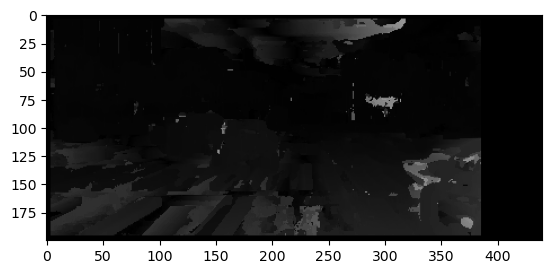

In [35]:
# Optised plotting of the disparity map
h,w = img_l_grey.shape
calc_disp2 = np.zeros((h,w))
boundary_size = 4
neighbourhood_l = 150
nighbourhood_r = 50
step_size = 1
measure = "SSD"

for row_index in tqdm(range(boundary_size, len(img_l_grey)-boundary_size, step_size)):
#     row = img_l_grey[row_index]
    for col_index_left in range(boundary_size,len(row)-boundary_size-50, step_size):
        # for col_index_left in range(600,602, step_size):
        centre_l = [row_index, col_index_left]

        min_l_x = centre_l[1] - boundary_size
        max_l_x = centre_l[1] + boundary_size

        min_l_y = centre_l[0] - boundary_size
        max_l_y = centre_l[0] + boundary_size

        patch_l = img_l_grey[min_l_y:max_l_y, min_l_x:max_l_x]

        # Take horizontal window to search, ensuring values don't exceed bounds
        min_bound = max(col_index_left-neighbourhood_l, boundary_size)
        max_bound = min(col_index_left+nighbourhood_r, len(row)-boundary_size)
        
        # Indices of all column centres to check
        col_centres = np.arange(min_bound,max_bound) 
        
        # Generate arrays for each column centre in steps of 1 using the boundary size, each having 2*boundary_size elements
        col_linspace = np.int32(np.transpose(np.linspace(col_centres-boundary_size, col_centres+boundary_size, 2*boundary_size)))

        # Generate right patch using the constant rows in loop iteration and column arrays, transpose to get correct shape
        patch_r = np.transpose(img_r_grey[min_l_y:max_l_y, col_linspace], (1,0,2)) 
        
        # Choose distance measure to generate disparity map
        if measure == "NCC":
            norm_corr = np.sum(patch_l*patch_r, axis=(1,2))/(np.linalg.norm(patch_l)*np.linalg.norm(patch_r, axis=(1,2)))
            min_col_index = np.argmax(norm_corr) + min_bound - 1
            calc_disp2[row_index][col_index_left] = abs(min_col_index - col_index_left)
        elif measure == "SSD":
            error = np.sum((patch_l-patch_r)**2, axis=(1,2))
            min_col_index = np.argmin(error) + min_bound - 1
            calc_disp2[row_index][col_index_left] = abs(min_col_index - col_index_left)

plt.imshow(calc_disp2, cmap='gray', vmin=0, vmax=255)



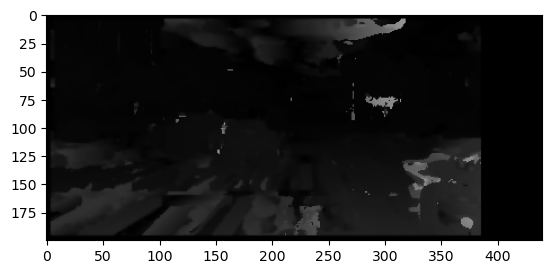

In [41]:
# Implement bilateral filter - edge preserving 
blur = cv2.bilateralFilter(np.uint8(calc_disp2),boundary_size,25,25)
plt.imshow(blur, cmap='gray', vmin=0, vmax=255)
